In [69]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [70]:
import numpy as np

In [71]:
import tensorflow as tf

# Linear Autoencoder as PCA

In [4]:
# Building a 3d dataset

In [5]:
import numpy.random as rnd

In [6]:
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

In [7]:
angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5

In [8]:
data = np.empty((m, 3))

In [9]:
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

In [12]:
X_train = scaler.fit_transform(data[:100])

In [13]:
X_test = scaler.transform(data[100:])

In [14]:
tf.reset_default_graph()

In [15]:
n_inputs = 3
n_hidden = 2  
n_outputs = n_inputs

In [16]:
learning_rate = 0.01

In [17]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [18]:
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

In [19]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [21]:
init = tf.global_variables_initializer()

In [22]:
n_iterations = 1000
codings = hidden

In [23]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

Text(0,0.5,'$d_2$')

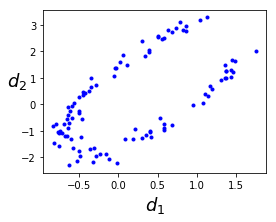

In [24]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$d_1$", fontsize=18)
plt.ylabel("$d_2$", fontsize=18, rotation=0)

# Stacked Autoencoders

In [25]:
tf.reset_default_graph()

In [26]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [27]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [28]:
learning_rate = 0.01
l2_reg = 0.0001

In [29]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [30]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [31]:
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

In [32]:
from functools import partial

In [33]:
configured_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

In [34]:
hidden1 = configured_dense_layer(X, n_hidden1)
hidden2 = configured_dense_layer(hidden1, n_hidden2)
hidden3 = configured_dense_layer(hidden2, n_hidden3)
outputs = configured_dense_layer(hidden3, n_outputs, activation=None)

In [35]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [36]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

In [37]:
loss = tf.add_n([reconstruction_loss] + reg_losses)

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 5
batch_size = 150

In [43]:
import sys

In [44]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.027040182
1 Train MSE: 0.013215956
2 Train MSE: 0.010909567
3 Train MSE: 0.010289508
4 Train MSE: 0.0104272235


# Tied weights of encoder and decoder

In [45]:
tf.reset_default_graph()

In [46]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [47]:
learning_rate = 0.01
l2_reg = 0.0005

In [48]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

In [49]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [50]:
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

In [52]:
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  
weights4 = tf.transpose(weights1, name="weights4")  

In [53]:
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

In [54]:
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

In [55]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

In [56]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [57]:
init = tf.global_variables_initializer()

In [58]:
saver = tf.train.Saver()

In [59]:
n_epochs = 5
batch_size = 150

In [60]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.01788037
1 Train MSE: 0.015834222
2 Train MSE: 0.016765831
3 Train MSE: 0.015495255
4 Train MSE: 0.01766818


In [64]:
n_test_digits = 2

In [65]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_tying_weights.ckpt")
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


In [67]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

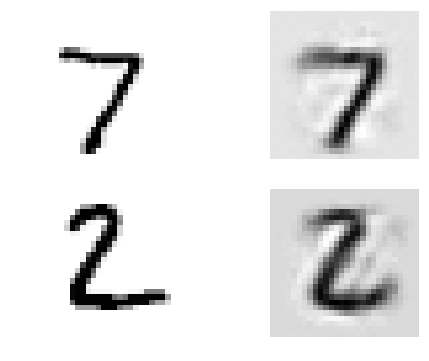

In [68]:
fig = plt.figure(figsize=(8, 3 * n_test_digits))
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

# Regular manual construction and training of mnist model

In [72]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

In [93]:
learning_rate = 0.01
l2_reg = 0.0005

In [94]:
tf.reset_default_graph()

In [74]:
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

In [75]:
activation = tf.nn.elu

In [76]:
initializer = tf.contrib.layers.variance_scaling_initializer()

In [77]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

In [78]:
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

In [79]:
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

In [80]:
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

In [81]:
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

In [82]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

In [84]:
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [85]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [86]:
init = tf.global_variables_initializer()

In [87]:
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])

In [88]:
saver = tf.train.Saver()

In [89]:
batch_size = 150
n_labeled_instances = 20000

In [90]:
n_epochs = 4


In [91]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.94 Test accuracy: 0.9208
1 Train accuracy: 0.9266667 Test accuracy: 0.9395
2 Train accuracy: 0.96666664 Test accuracy: 0.9495
3 Train accuracy: 0.96666664 Test accuracy: 0.9472


# Stacked denoising autoencoder

In [95]:
tf.reset_default_graph()

In [96]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [97]:
learning_rate = 0.01

In [98]:
noise_level = 1.0

In [99]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))


In [100]:
hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, 
                          name="hidden2")                            
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, 
                          name="hidden3")                            

In [101]:
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

In [102]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) 

In [103]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [104]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [105]:
n_epochs = 10
batch_size = 150


In [106]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.04287813
1 Train MSE: 0.04334128
2 Train MSE: 0.042675257
3 Train MSE: 0.039621174
4 Train MSE: 0.039343286
5 Train MSE: 0.042228173
6 Train MSE: 0.039421204
7 Train MSE: 0.042187296
8 Train MSE: 0.040558293
9 Train MSE: 0.042092193


## Using dropout as noise 

In [107]:
tf.reset_default_graph()

In [108]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [109]:
learning_rate = 0.01

In [110]:
dropout_rate = 0.3

In [111]:
training = tf.placeholder_with_default(False, shape=(), name='training')

In [112]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [113]:
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

In [114]:
hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, 
                          name="hidden2")                            
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, 
                          name="hidden3")                            
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs") 

In [115]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [116]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [117]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [118]:
n_epochs = 10
batch_size = 150

In [119]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.030606523
1 Train MSE: 0.025432646
2 Train MSE: 0.0266311
3 Train MSE: 0.02279642
4 Train MSE: 0.024642598
5 Train MSE: 0.023968054
6 Train MSE: 0.022686008
7 Train MSE: 0.022958076
8 Train MSE: 0.02384575
9 Train MSE: 0.021150297


In [120]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


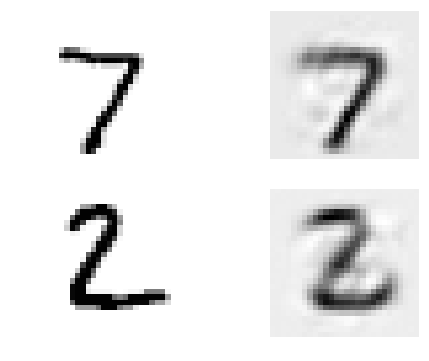

In [121]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## Sparse Autoencoder

In [123]:
p = 0.1

In [124]:
q = np.linspace(0.001, 0.999, 500)

In [125]:
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

In [126]:
mse = (p - q)**2

[0, 1, 0, 0.95]

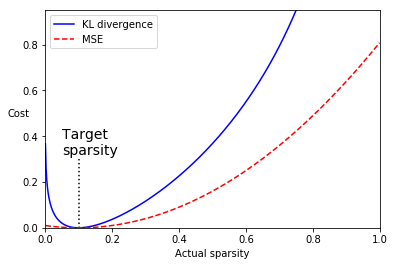

In [127]:
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [128]:
tf.reset_default_graph()

In [129]:
n_inputs = 28 * 28
n_hidden1 = 1000  
n_outputs = n_inputs

In [130]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [131]:
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

In [132]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [133]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) 
outputs = tf.layers.dense(hidden1, n_outputs) 

In [134]:
hidden1_mean = tf.reduce_mean(hidden1, axis=0) 
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) 
loss = reconstruction_loss + sparsity_weight * sparsity_loss

In [135]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [136]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [137]:
n_epochs = 100
batch_size = 1000

In [138]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13656385 	Sparsity loss: 0.20634961 	Total loss: 0.17783378
1 Train MSE: 0.058904905 	Sparsity loss: 0.06635445 	Total loss: 0.07217579
2 Train MSE: 0.053816114 	Sparsity loss: 0.027946616 	Total loss: 0.05940544
3 Train MSE: 0.047719955 	Sparsity loss: 0.015873186 	Total loss: 0.050894592
4 Train MSE: 0.045148447 	Sparsity loss: 0.22600076 	Total loss: 0.0903486
5 Train MSE: 0.041733395 	Sparsity loss: 0.019958083 	Total loss: 0.04572501
6 Train MSE: 0.038704053 	Sparsity loss: 0.18368998 	Total loss: 0.075442046
7 Train MSE: 0.03526295 	Sparsity loss: 0.24329059 	Total loss: 0.08392107
8 Train MSE: 0.034811206 	Sparsity loss: 0.06640546 	Total loss: 0.0480923
9 Train MSE: 0.029512053 	Sparsity loss: 0.08089571 	Total loss: 0.045691196
10 Train MSE: 0.02827405 	Sparsity loss: 0.06579653 	Total loss: 0.041433357
11 Train MSE: 0.025596332 	Sparsity loss: 0.026454516 	Total loss: 0.030887235
12 Train MSE: 0.02412207 	Sparsity loss: 0.11974923 	Total loss: 0.048071917
13 Tr

## Variational Autoencoders

In [151]:
tf.reset_default_graph()

In [152]:
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

In [153]:
initializer = tf.contrib.layers.variance_scaling_initializer()

In [154]:
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

In [155]:
X = tf.placeholder(tf.float32, [None, n_inputs])

In [156]:
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

In [157]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [158]:
eps = 1e-10 
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [159]:
loss = reconstruction_loss + latent_loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [160]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [161]:
n_digits = 60
n_epochs = 50
batch_size = 150

In [162]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  
        saver.save(sess, "./my_model_variational.ckpt")  
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 30830.078 	Reconstruction loss: 23968.564 	Latent loss: 6861.5127
1 Train total loss: 31382.96 	Reconstruction loss: 23436.36 	Latent loss: 7946.601
2 Train total loss: 26450.9 	Reconstruction loss: 22064.307 	Latent loss: 4386.5938
3 Train total loss: 20626.299 	Reconstruction loss: 17864.861 	Latent loss: 2761.438
4 Train total loss: 26371.062 	Reconstruction loss: 20726.852 	Latent loss: 5644.211
5 Train total loss: 25127.28 	Reconstruction loss: 21113.18 	Latent loss: 4014.1
6 Train total loss: 19171.395 	Reconstruction loss: 16538.967 	Latent loss: 2632.4272
7 Train total loss: 18683.314 	Reconstruction loss: 15614.35 	Latent loss: 3068.9653
8 Train total loss: 16507.453 	Reconstruction loss: 13492.785 	Latent loss: 3014.6682
9 Train total loss: 17054.553 	Reconstruction loss: 13882.225 	Latent loss: 3172.3286
10 Train total loss: 16508.451 	Reconstruction loss: 13366.2705 	Latent loss: 3142.18
11 Train total loss: 16289.0 	Reconstruction loss: 13035.066 	Laten

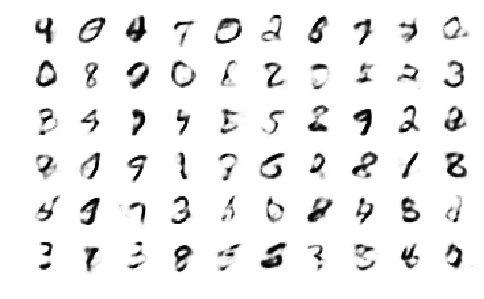

In [163]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

In [164]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

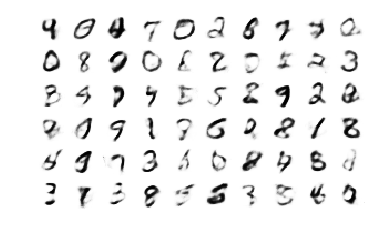

In [166]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)


In [167]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

In [168]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [170]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


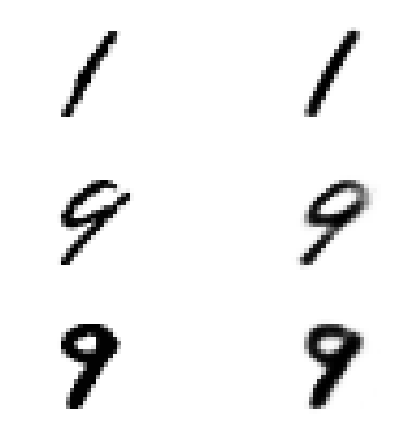

In [171]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])